In [221]:
from rsv_utils import add_syn_mut_attribute, add_changes_from_root_attr, DateToStr
from augur.utils import json_to_tree
from os import path
import pandas as pd
import numpy as np
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Seq import MutableSeq
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio.SeqRecord import SeqRecord
from Bio import AlignIO
from Bio.Align import MultipleSeqAlignment
from Bio.Align import AlignInfo
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime, date
import calendar
import time
import math
import json
import string
import requests

### Find nonsynonymous and synonymous divergence in different genes and plot the ratio of dN/dS

In [222]:
def get_rsv_genome_info(subtype):
    """
    Read in the reference file and generate dictionaries that store sequence and position information for the functions below
    """
    # make dictionary with gene name as key and reference sequence of that gene as value
    reference_sequence_aa = {}
    reference_sequence_nt = {}

    # make dictionary giving gene by genomic location
    reference_gene_locations = {}

    # make dictionary saying what codon within the gene a certain genomic location falls within
    # and whether the mutation is at pos 0, 1 or 2 within codon
    reference_gene_codon = {}

    for record in SeqIO.parse(open(f"../rsv_step3/config/rsv_{subtype}_step3_reference.gb","r"), "genbank"):
        genome_seq = record.seq
        for feature in record.features:
            if feature.type == 'CDS':
                # allow RdRp to overwrite Orf1a and Orf1b,
                # to take care of changed reading frame due to  ribosome slippage
                # S1 and S2 will also overwrite spike
                for pos in range(int(feature.location.start), int(feature.location.end)):
                    reference_gene_locations[pos] = feature.qualifiers['gene'][0]
                    codon_num = math.floor((pos-feature.location.start)/3)
                    pos_in_codon = ((pos-feature.location.start)-codon_num*3)
                    reference_gene_codon[pos] = (codon_num, pos_in_codon)

                gene_seq = feature.location.extract(record.seq)
                reference_sequence_nt[feature.qualifiers['gene'][0]] = gene_seq
                gene_seq_aa = gene_seq.translate()
                reference_sequence_aa[feature.qualifiers['gene'][0]] = gene_seq_aa

    # make dictionary with length of each gene
    gene_lengths_aa = {k:len(v) for k,v in reference_sequence_aa.items()}
    
    return reference_sequence_nt, reference_sequence_aa, reference_gene_locations, reference_gene_codon, gene_lengths_aa


In [223]:
#Get information about gene locations for RSV-A

reference_sequence_nt_A, reference_sequence_aa_A, reference_gene_locations_A, reference_gene_codon_A, gene_lengths_aa_A = get_rsv_genome_info('A')


In [224]:
#Get information about gene locations for RSV-B

reference_sequence_nt_B, reference_sequence_aa_B, reference_gene_locations_B, reference_gene_codon_B, gene_lengths_aa_B = get_rsv_genome_info('B')


In [253]:
#Lookup dictionary for gene information by subtype
ref_info = {'A': {'reference_sequence_nt': reference_sequence_nt_A, 
                  'reference_sequence_aa': reference_sequence_aa_A, 
                  'reference_gene_locations': reference_gene_locations_A, 
                  'reference_gene_codon': reference_gene_codon_A, 
                  'gene_lengths_aa': gene_lengths_aa_A}, 
            'A1': {'reference_sequence_nt': reference_sequence_nt_A, 
                  'reference_sequence_aa': reference_sequence_aa_A, 
                  'reference_gene_locations': reference_gene_locations_A, 
                  'reference_gene_codon': reference_gene_codon_A, 
                  'gene_lengths_aa': gene_lengths_aa_A}, 
            'A2': {'reference_sequence_nt': reference_sequence_nt_A, 
                  'reference_sequence_aa': reference_sequence_aa_A, 
                  'reference_gene_locations': reference_gene_locations_A, 
                  'reference_gene_codon': reference_gene_codon_A, 
                  'gene_lengths_aa': gene_lengths_aa_A}, 
            'B': {'reference_sequence_nt': reference_sequence_nt_B, 
                  'reference_sequence_aa': reference_sequence_aa_B, 
                  'reference_gene_locations': reference_gene_locations_B, 
                  'reference_gene_codon': reference_gene_codon_B, 
                  'gene_lengths_aa': gene_lengths_aa_B}}


In [226]:
def get_tree(subtype):
    """
    Read in the tree and add an attribute to each node listing synonymous mutations
    """
    
    #all genes in the genome
    gene_list = list(ref_info[subtype]['gene_lengths_aa'].keys())
    
    tree_json_file = f'../rsv_builds_for_divergence/auspice/rsv_{subtype}.json'
    
    with open(tree_json_file, 'r') as f:
        tree_json = json.load(f)

    #Put tree in Bio.Phylo format
    tree = json_to_tree(tree_json)
    
    #add synonymous mutations as an attribute of the tree
    tree = add_syn_mut_attribute(tree, ref_info[subtype]['reference_gene_locations'], 
                                 ref_info[subtype]['reference_gene_codon'],
                                 ref_info[subtype]['reference_sequence_nt'], 
                                 ref_info[subtype]['reference_sequence_aa'])
    
    #add an attribute to each node that lists all mutations that have occurred between the root and node
    tree = add_changes_from_root_attr(tree, gene_list)
    
    return tree

In [254]:
tree_A = get_tree('A')

/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.9/site-packages/Bio/Seq.py:2749: BiopythonDeprecationWarning: myseq.toseq() is deprecated; please use Seq(myseq) instead.
  warnings.warn(


In [228]:
tree_A1 = get_tree('A1')

In [255]:
tree_A2 = get_tree('A2')

In [229]:
tree_B = get_tree('B')

In [256]:
#store both trees in a dict by subtype name

tree_by_subtype = {'A': tree_A, 'A1': tree_A1, 'A2': tree_A2, 'B': tree_B}

For each time window, compute dN/dS for each isolate within the window. For each internal branch, the following function finds gene-specific nonsynonymous and synonymous divergence and then calculates the dN/dS ratio. Divergence here is the Hamming distance from the root normalized by the total number of synonymous or nonsynonymous sites in the gene.

In [257]:
def find_duplication_pos(subtype):
    """
    Since divergence is being measured from the root, and all root sequences 
    will not have the duplication (just --- at this region), and it doesn't make 
    sense to compute divergence from ---, want to ignore duplicated region
    Also ignore template of duplication for now
    """
    with open(f'../rsv_builds_for_divergence/auspice/rsv_{subtype}_root-sequence.json', 'r') as f:
        root_json = json.load(f)
        
    duplication_len = {'A':72, 'A1':72, 'A2':72, 'B': 60}
    
    #location of the duplication within the genome
    loc_dup_start = root_json['nuc'].find('-'*duplication_len[subtype])
    
    loc_dup = (loc_dup_start, loc_dup_start+duplication_len[subtype])
    
    #location of the duplication within G
    for record in SeqIO.parse(open(f"../rsv_builds_for_divergence/config/rsv_{subtype}_step3_reference.gb","r"), "genbank"):
        for feature in record.features:
            if feature.type == 'CDS':
                if feature.qualifiers['gene'][0] == 'G':
                    G_start = feature.location.start

                    
    loc_dup_start_G = loc_dup_start - G_start
    
    loc_dup_G_nt = (loc_dup_start_G, loc_dup_start_G+duplication_len[subtype])
    loc_dup_G_aa = tuple(int(x/3) for x in loc_dup_G_nt)

    
    return loc_dup, loc_dup_G_aa, loc_dup_G_nt

In [232]:
def find_nonsyn_syn_denominators(subtype):
    
    reference_sequence_nt = ref_info[subtype]['reference_sequence_nt']
    reference_sequence_aa = ref_info[subtype]['reference_sequence_aa']
    
    
    # get the position of the duplication, to ignore this region
    loc_dup, loc_dup_G_aa, loc_dup_G_nt = find_duplication_pos(subtype)
    
    
    denominators = {}
    
    for gene,nt_seq in reference_sequence_nt.items():
        
        seq = str(nt_seq)
        aa_seq = str(reference_sequence_aa[gene])


        nonsyn_denominator = 0
        syn_denominator = 0

        all_nts = ['A', 'C', 'G', 'T']

        for pos in range(len(seq)):
            #remove duplication region
            if gene == 'G' and pos in range(loc_dup_G_nt[0],loc_dup_G_nt[1]):
                pass
                
            else:
                nt = seq[pos]
                if nt!='N':

                    codon = math.floor(pos/3)
                    codon_pos = pos-(codon*3)
                    real_codon_aa = aa_seq[codon]

                    all_other_nts = [x for x in all_nts if x != nt]
                    for mutated_nt in all_other_nts: 
                        if codon_pos == 0:
                            mut_codon_nt = mutated_nt+seq[pos+1:(pos+3)]
                        elif codon_pos == 1:
                            mut_codon_nt = seq[pos-1]+mutated_nt+seq[pos+1]
                        elif codon_pos == 2:
                            mut_codon_nt = seq[(pos-2):pos]+mutated_nt

                        mut_codon_aa = Seq(mut_codon_nt).translate()

                        if mut_codon_aa!=real_codon_aa:
                            nonsyn_denominator+=1
                        elif mut_codon_aa==real_codon_aa:
                            syn_denominator+=1
                        
            
        denominators[gene] = {'nonsyn_denominator': nonsyn_denominator, 'syn_denominator':syn_denominator}
        
    return denominators

Calculate the total number of nonsynonymous or synonymous sites (denominators)

In [258]:
denominators_A = find_nonsyn_syn_denominators('A')
denominators_A1 = find_nonsyn_syn_denominators('A1')
denominators_A2 = find_nonsyn_syn_denominators('A2')
denominators_B = find_nonsyn_syn_denominators('B')

In [259]:
# dictionary of denominators by subtype
denominators_by_subtype = {'A':denominators_A, 'A1':denominators_A1, 'A2':denominators_A2, 'B':denominators_B}

Time windows for Fig2 will be 2 calendar months, and human readable. Make a list of time window start and end dates, in human readable dates and decimal years. For plotting, use the date at the middle of the window. For example, if window includes all of March and April 2020 (Mar-01-2020 to Apr-30-2020), plot this at April 1 2020. Use sliding windows that overlap by one month

In [235]:
def toYearFraction(date):
    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = datetime(year=year, month=1, day=1)
    startOfNextYear = datetime(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction

In [236]:
# find the start date and end date of the build

def get_build_dates(subtype):
    tree = tree_by_subtype[subtype]
    
    last_timepoint = 0
    first_timepoint = 2000
    for node in tree.find_clades():
        if node.node_attrs['num_date']['value'] > last_timepoint:
            last_timepoint = node.node_attrs['num_date']['value']
        if node.node_attrs['num_date']['value'] < first_timepoint:
            first_timepoint = node.node_attrs['num_date']['value']
    
    last_date = DateToStr(last_timepoint)
    last_date = datetime.strptime(last_date, '%b-%d-%Y')
    first_date = DateToStr(first_timepoint)
    first_date = datetime.strptime(first_date, '%b-%d-%Y')
    
    return first_date, last_date

In [237]:
def make_time_windows(subtype, window_size):
    """
    Make sliding windows of length `window_size` (in years) that are offset by 1 year
    """
    
    first_date, last_date = get_build_dates(subtype)
    
    time_windows = []

    for year in range(first_date.year, last_date.year-window_size):
        window_start = year
        window_end = year+window_size
        window_midpoint = (window_start+window_end)/2
        window_midpoint_str = DateToStr(window_midpoint)
     
        time_windows.append({'window_start_decimal': float(window_start), 
                             'window_end_decimal': float(window_end), 'window_midpoint_decimal': float(window_midpoint), 
                        'window_start': datetime.strptime(str(window_start), '%Y'), 
                        'window_end': datetime.strptime(str(window_end), '%Y'), 
                        'window_midpoint': datetime.strptime(window_midpoint_str, '%b-%d-%Y')})
                
    return time_windows

In [238]:
def mask_duplication_region_aa(subtype, mut_list):
    
    loc_dup, loc_dup_G_aa, loc_dup_G_nt = find_duplication_pos(subtype)
    
    mut_pos = [x[1:-1] for x in mut_list]
    
    mut_list_masked = []
    for x in mut_list:
        if int(x[1:-1]) not in range(loc_dup_G_aa[0], loc_dup_G_aa[1]):
            mut_list_masked.append(x)
            
    
    return mut_list_masked


In [239]:
def mask_duplication_region_nt(subtype, mut_list):
    
    loc_dup, loc_dup_G_aa, loc_dup_G_nt = find_duplication_pos(subtype)
    
    mut_pos = [x[1:-1] for x in mut_list]
    
    mut_list_masked = []
    for x in mut_list:
        if int(x[1:-1]) not in range(loc_dup[0], loc_dup[1]):
            mut_list_masked.append(x)
            
    
    return mut_list_masked


In [290]:
def find_divergence_in_window(subtype, gene_list, window_size=10):
    
    #make sliding time windows
    time_windows = make_time_windows(subtype, window_size)
    
    window_dnds_info = []
    
    tree = tree_by_subtype[subtype]
    
    
    # look at divergence within time window
    for x in range(0,len(time_windows)):
        start_date = float(time_windows[x]['window_start_decimal'])
        end_date = float(time_windows[x]['window_end_decimal'])
        
        nonsyn_div_in_window = []
        syn_div_in_window = []

        for node in tree.find_clades(terminal=False):
            if node.node_attrs['num_date']['value']>=start_date and  node.node_attrs['num_date']['value']<=end_date:
                
                for gene in gene_list:
                    gene_nonsyn_denom = denominators_by_subtype[subtype][gene]['nonsyn_denominator'] 
                    gene_syn_denom = denominators_by_subtype[subtype][gene]['syn_denominator']
                    
                    #divergence accumulation
                    #mask duplication region
                    masked_nonsyn_muts = mask_duplication_region_aa(subtype, node.branch_attrs["changes_from_root"]['nonsyn'][gene])
                    gene_nonsyn_divergence = len(masked_nonsyn_muts)/gene_nonsyn_denom
                    
                    #assign a false count to avoid dividing by zero
                    masked_syn_muts = mask_duplication_region_nt(subtype, node.branch_attrs["changes_from_root"]['syn'][gene])
                    if len(masked_syn_muts) == 0:
                        gene_syn_divergence = 1/gene_syn_denom
                    else:
                        gene_syn_divergence = len(masked_syn_muts)/gene_syn_denom

                    
                    
                    dn_over_ds = gene_nonsyn_divergence/gene_syn_divergence
                    
                    window_dnds_info.append({'window_start': time_windows[x]['window_start_decimal'],  
                                             'window_end': time_windows[x]['window_end_decimal'], 
                                             'window_midpoint': time_windows[x]['window_midpoint_decimal'], 
                                             'dn': gene_nonsyn_divergence, 'ds': gene_syn_divergence,
                                             'dn/ds':dn_over_ds, 'location': gene})

    window_dnds_df = pd.DataFrame(window_dnds_info)

        

    return window_dnds_df
        

In [291]:
dnds_df_A= find_divergence_in_window('A', list(ref_info['A']['gene_lengths_aa'].keys()))
dnds_df_A1= find_divergence_in_window('A1', list(ref_info['A1']['gene_lengths_aa'].keys()))
dnds_df_A2= find_divergence_in_window('A2', list(ref_info['A2']['gene_lengths_aa'].keys()))
dnds_df_B= find_divergence_in_window('B', list(ref_info['B']['gene_lengths_aa'].keys()))

In [292]:
dnds_df_by_subtype = {'A': dnds_df_A, 'A1': dnds_df_A1, 'A2': dnds_df_A2, 'B':dnds_df_B}

In [293]:
mean_overall_G_A = dnds_df_A[dnds_df_A['location']=='G']['dn/ds'].mean()
mean_overall_G_A1 = dnds_df_A1[dnds_df_A1['location']=='G']['dn/ds'].mean()
mean_overall_G_A2 = dnds_df_A2[dnds_df_A2['location']=='G']['dn/ds'].mean()
mean_overall_G_B = dnds_df_B[dnds_df_B['location']=='G']['dn/ds'].mean()
print(f'Overall mean dn/ds in G:\n RSV-A:{mean_overall_G_A}\n RSV-A1:{mean_overall_G_A1}\n RSV-A2:{mean_overall_G_A2}\n RSV-B:{mean_overall_G_B}')

mean_overall_F_A = dnds_df_A[dnds_df_A['location']=='F']['dn/ds'].mean()
mean_overall_F_A1 = dnds_df_A1[dnds_df_A1['location']=='F']['dn/ds'].mean()
mean_overall_F_A2 = dnds_df_A2[dnds_df_A2['location']=='F']['dn/ds'].mean()
mean_overall_F_B = dnds_df_B[dnds_df_B['location']=='F']['dn/ds'].mean()
print(f'Overall mean dn/ds in F:\n RSV-A:{mean_overall_F_A}\n RSV-A1:{mean_overall_F_A1}\n RSV-A2:{mean_overall_F_A2}\n RSV-B:{mean_overall_F_B}')

mean_overall_L_A = dnds_df_A[dnds_df_A['location']=='L']['dn/ds'].mean()
mean_overall_L_A1 = dnds_df_A1[dnds_df_A1['location']=='L']['dn/ds'].mean()
mean_overall_L_A2 = dnds_df_A2[dnds_df_A2['location']=='L']['dn/ds'].mean()
mean_overall_L_B = dnds_df_B[dnds_df_B['location']=='L']['dn/ds'].mean()
print(f'Overall mean dn/ds in L:\n RSV-A:{mean_overall_L_A}\n RSV-A1:{mean_overall_L_A1}\n RSV-A2:{mean_overall_L_A2}\n RSV-B:{mean_overall_L_B}')


Overall mean dn/ds in G:
 RSV-A:0.2392421196022687
 RSV-A1:0.170254808263163
 RSV-A2:0.46878389328587267
 RSV-B:0.1950081222748983
Overall mean dn/ds in F:
 RSV-A:0.034583040065695854
 RSV-A1:0.02098777708642557
 RSV-A2:0.09222269082460223
 RSV-B:0.028647650567800817
Overall mean dn/ds in L:
 RSV-A:0.03573161377174908
 RSV-A1:0.0371481292035426
 RSV-A2:0.027802089249594805
 RSV-B:0.039398831048851814


In [329]:
def plot_divergence_accumulation(subtype, filename=None):
    genes_to_plot = ['NS2', 'N', 'P', 'M', 'G', 'F', 'L']
    
    subtype_df = dnds_df_by_subtype[subtype]

    df_to_plot = subtype_df[subtype_df['location'].isin(genes_to_plot)]

    cmap = {'N':"#d90000", 'P':"#ffb2b2", 'M': '#307358', 'NS2': '#419D78', 
            'G': "#F5AD52", 'F': '#1b7ced', 'L':"#8b0000"}

    fig = plt.figure(figsize=(8, 5))
    ax1 = plt.subplot2grid((2, 2), (0, 0))
    ax2 = plt.subplot2grid((2, 2), (0, 1))
    ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)

    #what to plot on what axis
    data_to_plot = {0: 'dn', 1: 'ds', 2: 'dn/ds'}
    y_axis_label = {0: 'dN', 1:'dS', 2:'dN/dS'}
    x_axis_label = {0: '', 1:'', 2:'date'}
    whether_to_plot_legend = {0: False, 1: False, 2:True}

    axs = [ax1,ax2,ax3]
    for k in range(len(axs)):
        sns.lineplot(x='window_start', y=data_to_plot[k], hue='location', 
                  data=df_to_plot, palette=cmap, linewidth=2, hue_order = ['G', 'F', 'L', 'N', 'P', 'M', 'NS2'],
                  ci=95, ax=axs[k], legend = whether_to_plot_legend[k])

        axs[k].set_xlabel(x_axis_label[k], fontsize=14)
        axs[k].set_ylabel(y_axis_label[k], fontsize=14)
        
        axs[k].tick_params(axis='both',labelsize=12)



    fig.suptitle(f'RSV-{subtype} divergence accumulation', fontsize=16)
    plt.tight_layout()
    sns.set_style("white")
    sns.despine(left=False, bottom=False)


    handles, labels = ax3.get_legend_handles_labels()
    lgd = ax3.legend(handles, labels, loc='upper center', fontsize=12, bbox_to_anchor=(1.1, 1.7), 
                             title = r'$\bf{Gene}$')
    if filename:
        fig.savefig(filename, dpi=300, bbox_inches='tight')

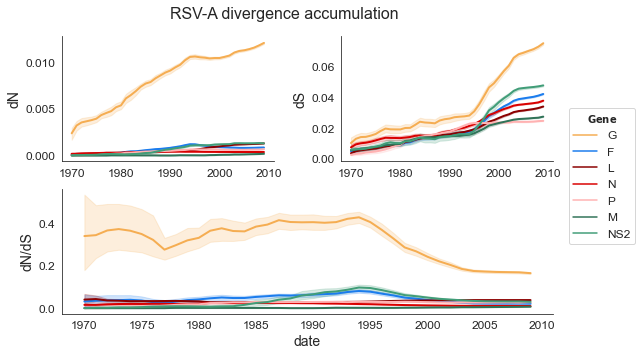

In [330]:
plot_divergence_accumulation('A', 'plots/RSV-A_divergence_accumulation.png')

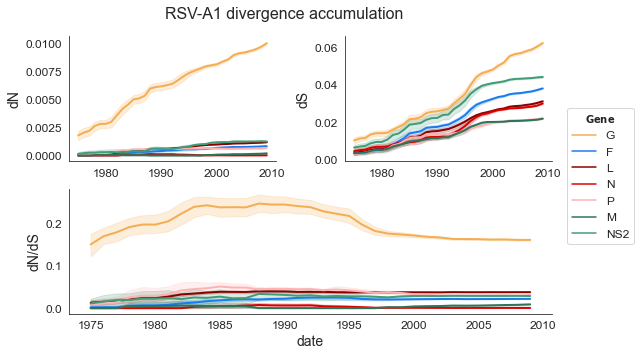

In [331]:
plot_divergence_accumulation('A1', 'plots/RSV-A1_divergence_accumulation.png')

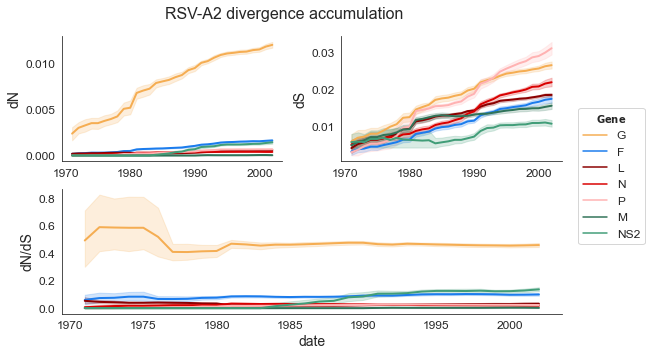

In [332]:
plot_divergence_accumulation('A2', 'plots/RSV-A2_divergence_accumulation.png')

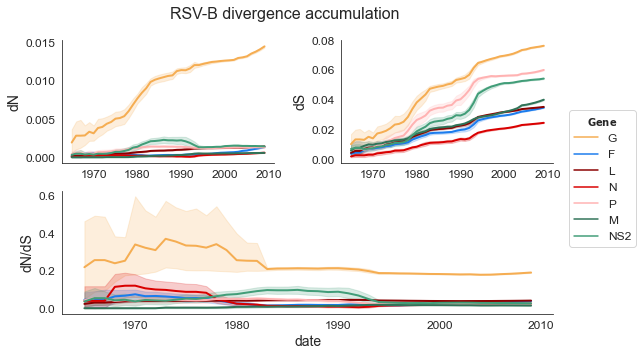

In [333]:
plot_divergence_accumulation('B', 'plots/RSV-B_divergence_accumulation.png')